In [1]:
import torch
print("PyTorch version:", torch.__version__)
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
import tensorflow as tf
print("\nTensorFlow version:", tf.__version__)
print(tf.config.list_physical_devices('GPU'))

PyTorch version: 2.1.2
NVIDIA GeForce GTX 1080

TensorFlow version: 2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Some basic imports + dataset information

This version of casme has 200 FPS frames, and 4DME have 60 FPS. We will train our models on CASME, then evaluate on 4DME dataset, we will perform selected preprocessing steps separately for each dataset.

In [2]:
from meb import datasets
from meb.datasets import sampling, dataset_utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import seaborn as sns

TARGET_SIZE = [224, 224]
casme2 = datasets.Casme2(resize=TARGET_SIZE)
df = casme2.data_frame
data = casme2.data
display(df.head(10))

,subject,material,onset,apex,offset,AU,emotion,n_frames,AU1,AU2,...,AU14,AU15,AU16,AU17,AU18,AU20,AU24,AU25,AU26,AU38
0,01,EP02_01f,46,59,86,12,happiness,41,0,0,...,0,0,0,0,0,0,0,0,0,0
1,01,EP03_02,131,139,161,18,others,31,0,0,...,0,0,0,0,1,0,0,0,0,0
2,01,EP04_02,21,54,76,4,others,56,0,0,...,0,0,0,0,0,0,0,0,0,0
3,01,EP04_03,31,41,56,4,others,26,0,0,...,0,0,0,0,0,0,0,0,0,0
4,01,EP04_04,23,49,66,4,others,44,0,0,...,0,0,0,0,0,0,0,0,0,0
5,01,EP19_01,26,49,66,4,others,41,0,0,...,0,0,0,0,0,0,0,0,0,0
6,01,EP19_03f,81,96,161,4,others,81,0,0,...,0,0,0,0,0,0,0,0,0,0
7,01,EP19_05f,396,416,446,4+L10,disgust,51,0,0,...,0,0,0,0,0,0,0,0,0,0
8,01,EP19_06f,36,71,161,4+5+L10,disgust,126,0,0,...,0,0,0,0,0,0,0,0,0,0
9,02,EP01_11f,46,91,96,15,repression,51,0,0,...,0,1,0,0,0,0,0,0,0,0


CASME2 consists of 256 episodes, below example resized face image (gray scaled)

(256, 41, 224, 224)


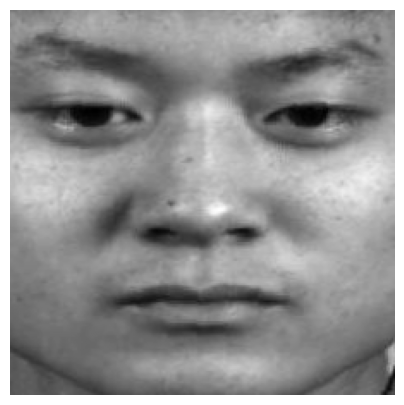

In [3]:
print(data.shape)
plt.figure(figsize=(5,5))
plt.imshow(data[0][0], cmap="gray")
plt.axis(False)
plt.show()

### Uniformly sampling frames, magnifying, extracting optical flow, and loading all data

In our pipeline we will perform temportal normalization of episodes, in other words we will pick N frames from each episode regardless of episode duration, it has some pros and cons.
Cons: we keep whole episode as one single entity, and model learns to recognize general pattern, cons we lose temporal dependency within episode, in other words we are fitting random time intervals into predifined number of frames.

Parameters in Eulerian Motion Magnification Method: alpha=10, r1=0.47, r2=0.1, n_levels=6, lambda_c=16  
1. R1 - Upper bound frequency cutoff  
2. R2 - Lower bound frequency cutoff   
So, we amplify everything in between.  
3. Alpha is amplification coefficient
4. n_levels - Number of Laplacian Pyramid levels (it is the difference between two consecutive Gaussian Pyramids, where lower in upsampled)
5.  Lambda_c controls how alpha will be applied to each level, higher the lambda_c for more it will amplify higher (or lower depends on the implementation of ordering) levels of laplacian pyramids, thus focus on more subtle actions.  
R1 and R2 are actually normalized frequency coeffcients for the bandpass filter, in this case it almost as EWMA but in temporal domain of each pyramid level.
We set r1 = 0.47 according to the nyquist frquency (max 0.5), if target FPS is 30 then frequencies up to 14 Hz are considered

For optical flow extraction is used Gunnar Farneback's method, in addition to the flow vectors we extract optical strains based on Sobel kernels. There are also other methods available, for instance DualTVL1, while it can give better result, it is more computationally complex, and impacts the performance.  

Explanation of parameters in OpenCV Farneback method:

| Parameter  | Meaning | Effect |
| -----------| ----------------------------------------------------------------------| -------------------------------------------------------------------------------------------------|
| pyr_scale  | Image scale (<1) between pyramid levels (usually 0.3–0.8).            | Smaller scale (0.3), more global motion, smoother flow. Larger, more detail, possibly more noise.|
| levels     | Number of pyramid levels.                                             | More levels (5–6) the better handling of large motion, smoother overall flow.                    |
| winsize    | Averaging window size (odd numbers eg. 15, 21 etc).                   | Larger window, more smoothing, less noise, but less detail and slower response to motion.        |
| iterations | Iterations at each pyramid level.                                     | More iterations, more stable convergence, slightly smoother results (3–5 is ok).                 |
| poly_n     | Size of the pixel neighborhood used for polynomial expansion (5 or 7).| Larger (7), smoother, denoised motion field. Smaller (5), more detailed but noisier.             |
| poly_sigma | Standard deviation of Gaussian used for polynomial smoothing.         | Higher (1.5), more smoothing, denoising. Lower (1.1), more detail, more noise.                   |
| flags      | Usually 0 or can be cv2.OPTFLOW_FARNEBACK_GAUSSIAN.                   | Using cv2.OPTFLOW_FARNEBACK_GAUSSIAN adds an extra Gaussian smoothing step, may reduce noise.    |


In [4]:
import py_evm
from scipy import ndimage
import joblib

#some helper functions for video and image processing

def flow_to_hsv(matrix):
    #Converts u,v (optical flow) to HSV image.
    magnitude, angle = cv2.cartToPolar(matrix[..., 0], matrix[..., 1], angleInDegrees=True)
    hsv = np.zeros((matrix.shape[0], matrix.shape[1], 3), dtype=np.uint8)
    hsv[...,0] = (angle / 2).astype(np.uint8)          # hue is: 0-180
    hsv[...,1] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)                                  #  255 full saturation
    #combined = magnitude * 0.5 + matrix[..., 2] * 0.5 # half magnitude of vector, half strain
    hsv[...,2] = cv2.normalize(matrix[..., 2], None, 0, 255, cv2.NORM_MINMAX)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return bgr

def flow_to_gray(matrix):
    new_mat = np.reshape(matrix[..., 2], matrix.shape[:2])
    return cv2.normalize(new_mat, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)


def write_video(name, matrix, fps: int, color: bool):
    out = cv2.VideoWriter(name ,cv2.VideoWriter_fourcc(*'mp4v'), fps, (matrix.shape[2], matrix.shape[1]), color) # W, H for opencv
    frame_count = matrix.shape[0]
    flow_to_hsv_flag = len(matrix.shape) == 4 
    is_float = matrix.dtype != np.uint8
    for i in range(frame_count): 
        frame = matrix[i]  
        if color and flow_to_hsv_flag:
            out.write(flow_to_hsv(frame))
        elif flow_to_hsv_flag: # 4 dims is only applicable to flow in this case, or raw 3 channel image, but we are intereseted in flow visualisation
            out.write(flow_to_gray(frame))
        else: 
            if is_float:
                frame = (frame * 255).astype(np.uint8)
            out.write(frame)
    out.release()
    print("Video written")

#Optical flow Farneback + strains (function slightly modified original function from MEB)

def get_optical_flow(video):
    def optical_strain(u: np.ndarray, v: np.ndarray) -> np.ndarray:
        """Compute optical strain from u and v components"""
        ux = ndimage.sobel(u, axis=0, mode="constant")
        uy = ndimage.sobel(u, axis=1, mode="constant")
        vx = ndimage.sobel(v, axis=0, mode="constant")
        vy = ndimage.sobel(v, axis=1, mode="constant")
        grad = np.sqrt(ux**2 + vy**2 + 0.5 * (uy**2 + vx**2))
        return grad

    def normalize_img(img: np.ndarray) -> np.ndarray:
        """Normalizes the image between [0, 1]"""
        img_min = img.min((0, 1))
        img_max = img.max((0, 1))
        normalized_img = (img - img_min) / (img_max - img_min)
        return normalized_img

    shape = list(video.shape)
    shape[0] -= 1
    shape.append(3)
    uv_frames = np.zeros(shape)

    for i in range(len(video) - 1):
        f1 = video[i]
        f2 = video[i + 1]
        flow = cv2.calcOpticalFlowFarneback(f1, f2, None, 0.5, 4, 15, 4, 5, 1.2, 0) #default parameters 0.5, 3, 15, 3, 5, 1.2, 0
        strain = optical_strain(flow[..., 0], flow[..., 1])
        uv_frame = np.concatenate([flow, np.expand_dims(strain, 2)], 2)
        uv_frame = normalize_img(uv_frame)
        uv_frames[i] = uv_frame

    return uv_frames


eulerian_params = {"alpha": 15, "r2": 0.1, "r1": 0.47}
max_duration = df["n_frames"].max()
example_i = int(df.loc[df["n_frames"] == max_duration].index[1])
#preprocessing

#this method performs temporal normalization, magnification, and sampling, all in one depending on the params
def preprocess_of_evm(data: dataset_utils.LazyDataLoader | np.ndarray, magnification_params: dict, optical_flow: bool = True,
                       magnify: bool = True, sample_first: bool = False, n_sample: int = 8, example_i: int = None, example_prefix: str = "_") -> np.ndarray:
    
    sampler = sampling.UniformTemporalSubsample(n_sample, 0) #uniform sampling
    episodes = len(data)
    data_loaded = None

    if optical_flow == False:
        data_loaded = np.zeros((episodes, n_sample, data.shape[2], data.shape[3]))
    else:
        data_loaded = np.zeros((episodes, n_sample - 1, data.shape[2], data.shape[3], 3))

    #gets the example first (some copy pasting of code here)
    if example_i:
        buff = data[example_i]
        if sample_first:
            buff = sampler(data[example_i])
        write_video(example_prefix + "original.mp4", buff, 30, False)

        if magnify:
            buff = py_evm.magnify(buff, **magnification_params)
            if not sample_first:
                buff = sampler(buff)
            write_video(example_prefix + "magnified.mp4", buff, 30, False)

        if optical_flow:
            if buff.dtype != np.uint8:
                buff = (buff * 255).astype(np.uint8)
            buff = get_optical_flow(buff)
            if not sample_first and not magnify:
                buff = sampler(buff)
            write_video(example_prefix + "optical_flow.mp4", buff, 30, True)

    for i in range(len(data)):
        buff = data[i]
        if sample_first:
            buff = sampler(buff)
        if magnify:
            buff = py_evm.magnify(buff, **magnification_params)
            if not sample_first:
                buff = sampler(buff)
        if optical_flow:
            if buff.dtype != np.uint8:
                buff = (buff * 255).astype(np.uint8)
            buff = get_optical_flow(buff)
            if not sample_first and not magnify:
                buff = sampler(buff)
        data_loaded[i] = buff

    return data_loaded

In [5]:
# First sample then magnify, and extract optical flow
#casme_loaded_sample_of_mag = preprocess_of_evm(data, eulerian_params, optical_flow=True, magnify=True, sample_first=True,  n_sample=8, example_i=example_i, example_prefix="sample_first_of_mag_")
#print(casme_loaded_sample_of_mag.shape)

# First magnify then sample and optical flow
casme_loaded_of_mag = preprocess_of_evm(data, eulerian_params, optical_flow=True, magnify=True, sample_first=False, n_sample=8, example_i=example_i, example_prefix="casme_mag_sample_of")
print(casme_loaded_of_mag.shape)
# Magnify and sample only
casme_loaded_magnify_only = preprocess_of_evm(data, eulerian_params, optical_flow=False, magnify=True, sample_first=False, n_sample=8, example_i=example_i, example_prefix="casme_mag_only_sample")
print(casme_loaded_magnify_only.shape)
# Sample first and optical flow only
casme_loaded_optical_only = preprocess_of_evm(data, eulerian_params, optical_flow=True, magnify=False, sample_first=True, n_sample=8, example_i=example_i, example_prefix="casme_of_only_sample")
print(casme_loaded_optical_only.shape)

Video written
Video written
Video written
(256, 7, 224, 224, 3)
Video written
Video written
(256, 8, 224, 224)
Video written
Video written
(256, 7, 224, 224, 3)


Dumping the results

In [6]:
#joblib.dump(casme_loaded_sample_of_mag, "../data/casme_loaded_sample_first.pkl")
joblib.dump(casme_loaded_of_mag.astype(np.float32), "../data/casme_mag_of.pkl ")
joblib.dump(casme_loaded_magnify_only.astype(np.float32), "../data/casme_magnify_only.pkl")
joblib.dump(casme_loaded_optical_only.astype(np.float32), "../data/casme_optical_only.pkl")

['../data/casme_optical_only.pkl']

### In addition we want to experiment with Optical Flow fused with LBP features, and 3D FFT

First, considering 3D FFT for our video, we start by performing a traditional 1D FFT along the temporal axis for each pixel's intensity value, producing a matrix of shape (H,W, F) where elements in F represent the two sided amplitude spectrum of each pixel. Next, to understand how these frequency amplitudes vary across each row, we perform an FFT decomposition along the horizontal dimension while keeping the height of block constant, producing a 2D FFT that captures pixel intensity decomposition across time and width, then, we analyze how the row wise frequency amplitudes vary along the vertical dimension by performing FFT along height while keeping width constant, and the resulting matrix, which will be still of shape (F,H,W), now represents the full 3D amplitude spectrum, capturing oscillations of pixel intensities across space and time.

We are doing it blockwise because we are extracting fluctuations in the different facial areas, in the example below video images are splitted into the 8x8 blocks, then we compute 3D FFT, and combine everything back as the set of facial area specific spatio-temporal features.

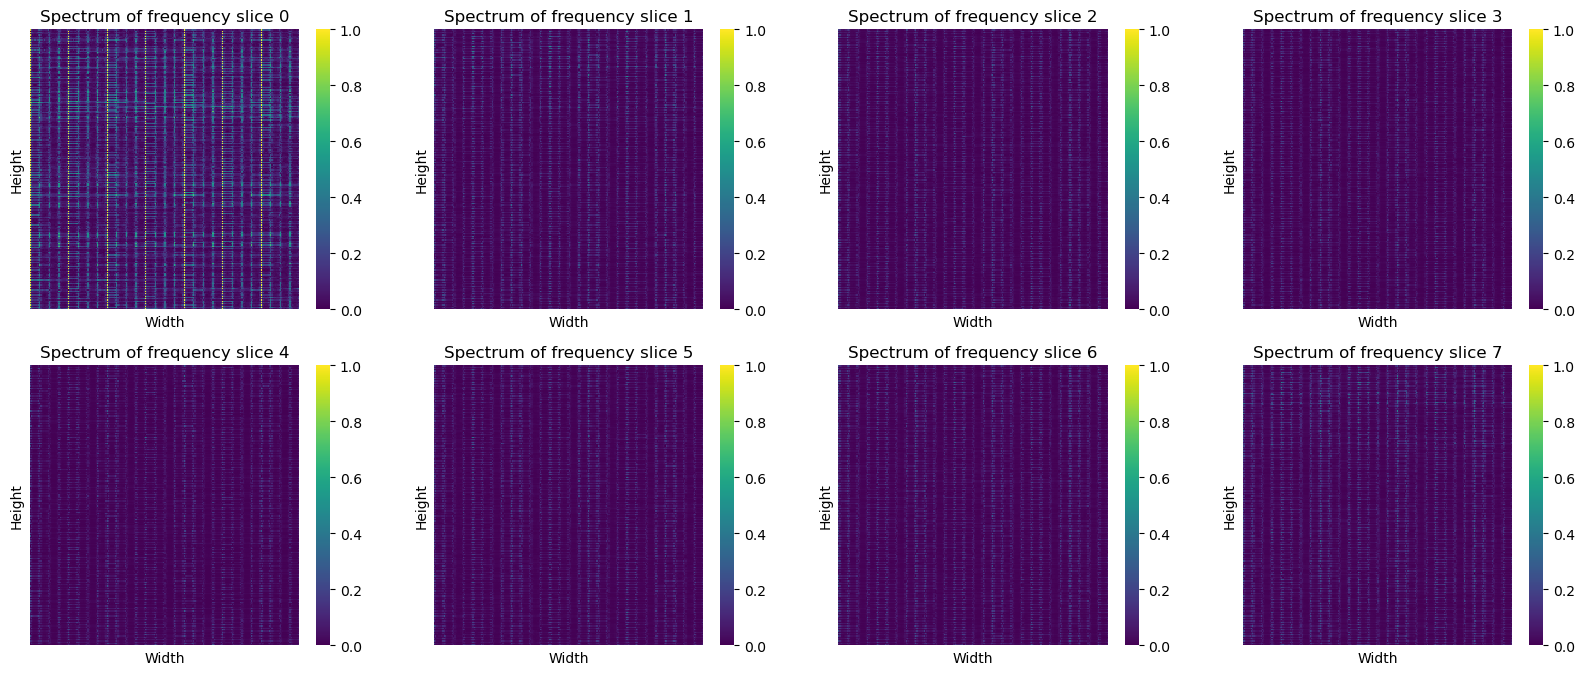

In [7]:
def regional_spatiotemporal_spectrum(data: np.ndarray, block_size: int = 8):
    T, H, W = data.shape
    if H != W:
        print("Images should have equal H and W")
        return None
    if H % block_size:
        print("Inconsitent block size")
        return None
    steps = H // block_size
    blocks = np.zeros((T, steps, steps, block_size, block_size))
    for j in range(steps):
        for k in range(steps):
            blocks[:, j, k] = data[:, j * block_size: (j + 1) *block_size, k * block_size: (k + 1)*block_size]
    
    for j in range(steps):
        for k in range(steps):
            blocks[:, j, k] = np.absolute(np.fft.fftn(blocks[:, j, k], axes=(0, 1, 2)))
            blocks[:, j, k] = np.log1p(blocks[:, j, k])
            min_b = np.min(blocks[:, j, k])
            max_b = np.max(blocks[:, j, k])
            blocks[:, j, k] = (blocks[:, j, k]  - min_b) / (max_b - min_b)
    return blocks.reshape(T, H, W)

#needs to be fixed, very high memory usage
def regional_spatiotemporal_spectrum_gpu(input, block_size: int = 8): 
    outputs = []
    B, T, H, W = input.shape
    if H != W:
        print("Images should have equal H and W")
        return None
    if H % block_size:
        print("Inconsitent block size")
        return None
    steps = H // block_size
    for i in range(B):
        blocks = []
        for j in range(steps):
            for k in range(steps):
                block = tf.cast(input[i, :, j * block_size: (j + 1) *block_size, k * block_size: (k + 1)*block_size], tf.complex64)
                block = tf.abs(tf.signal.fft3d(block))
                block = tf.math.log1p(block)
                min_b = tf.math.reduce_min(block)
                max_b = tf.math.reduce_max(block)
                blocks.append((block - min_b) / (max_b - min_b))          
        blocks = tf.transpose(blocks, (1, 0, 2, 3))
        outputs.append(tf.reshape(blocks, (T, H, W)))
    return tf.stack(outputs)

spectrum = regional_spatiotemporal_spectrum(casme_loaded_magnify_only[3])
spectrum_ = regional_spatiotemporal_spectrum_gpu(np.array([casme_loaded_magnify_only[3]]))[0].numpy()

H, W = spectrum_.shape[1:]
X, Y = np.meshgrid(np.arange(W), np.arange(H)) 
fig = plt.figure(figsize=(20,8))
for i, temporal_frequency in enumerate(spectrum_):
    plt.subplot(2, 4, i + 1)
    sns.heatmap(temporal_frequency, cmap="viridis", vmax=1, vmin=0)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.title(f"Spectrum of frequency slice {i}")
plt.show()

In [8]:
casme_regional_spatiotemporal_features = regional_spatiotemporal_spectrum_gpu(casme_loaded_magnify_only, 8)

In [9]:
joblib.dump(casme_regional_spatiotemporal_features, "../data/casme_regional_spatiotemporal_features.pkl")

['../data/casme_regional_spatiotemporal_features.pkl']

Secondly we will extract LBP features, LBP compares each neighboring pixel’s intensity with the center pixel’s intensity. If the neighbor ≥ center, it gets a 1, otherwise 0.  
LBP parameters:
1.  P: Number of neighbours: 8
2.  R: Radius of circle: 1  
Usage of nri_unifrom decreases computational complexity but reduces feature space, as it allows at most 1 transition 0 -> 1

In [10]:
from skimage.feature import local_binary_pattern
def extract_lbp(data, P = 8, R = 1.0, method = "nri_uniform"):
    video_data = (data * 255).astype(np.uint8) if data.dtype != np.uint8 else data
    output = []
    if len(data.shape) > 3:
        for video in video_data:
            video_buff = []
            for img in video:
                lbp = local_binary_pattern(img, P = P, R = R, method=method)
                lbp = lbp / np.max(lbp)
                video_buff.append(lbp)
            output.append(video_buff)
    else:
        for img in video_data:
            lbp = local_binary_pattern(img, P = P, R = R, method=method)
            lbp = lbp / np.max(lbp)
            output.append(lbp)
    return np.array(output)

casme_magnified_lbps = extract_lbp(casme_loaded_magnify_only)

We can then, for instance, fuse LBP features with optical flow or spatiotemporal features, for optical flow we will have to drop the first or last LBP frame, to make them align.

In [11]:
joblib.dump(casme_magnified_lbps.astype(np.float32), "../data/casme_magnified_lbps.pkl")

['../data/casme_magnified_lbps.pkl']

In [12]:
del casme_loaded_magnify_only
del casme_loaded_of_mag
del casme_loaded_optical_only
del casme_regional_spatiotemporal_features
del casme_magnified_lbps

## 4DME
Same preprocessing steps must be also performed on 4DME, evalutation dataset, or we can shuffle them later, during the modelling

,fold,subject,material,AU,emotion,eye blink,onset,apex,offset,apexf,...,AU15,AU17,AU20,AU24,AU25,AU39,AU43,AU45,AU63,AU64
0,1,S08,S08_002_01_1,AU5+45,Others,1,1831,1847,1855,17,...,0,0,0,0,0,0,0,1,0,0
1,1,S08,S08_003_02_2,AU7,Negative,0,5101,5107,5117,7,...,0,0,0,0,0,0,0,0,0,0
2,1,S08,S08_003_03_2,AUR20,Others,0,6590,6599,6605,10,...,0,0,1,0,0,0,0,0,0,0
3,1,S08,S08_005_01_1,AU7,Negative,0,424,430,438,7,...,0,0,0,0,0,0,0,0,0,0
4,1,S08,S08_008_01_1,AU1+2+5+45,Surprise,1,65,81,88,17,...,0,0,0,0,0,0,0,1,0,0


(267, 25, 224, 224)


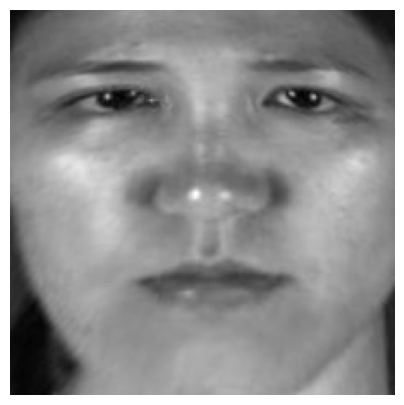

In [13]:
_4dme = datasets.Fourd(resize = TARGET_SIZE)
df_4dme = _4dme.data_frame
data_4dme = _4dme.data
display(df_4dme.head())
print(data_4dme.shape)
plt.figure(figsize=(5,5))
plt.imshow(data_4dme[50][0], cmap="gray")
plt.axis(False)
plt.show()

Joining datasets, we need only emotion + AU labels, we encode, and preprocess, them later, also, we will consider the AU labels which are present in both datasets.

In [14]:
AUs_casme = df.columns[8:].to_list()
AUs_4dme = df_4dme.columns[16:].to_list()
'''
all_AUs = list(set(AUs_casme + AUs_4dme))
casme_missing = [au for au in all_AUs if au not in AUs_casme]
_4dme_missing = [au for au in all_AUs if au not in AUs_4dme]
df[casme_missing] = 0
df_4dme[_4dme_missing] = 0
cols = ["emotion"] + all_AUs
'''
intersect = list(set(AUs_casme) & set(AUs_4dme)) + ["emotion"]
joint_df = pd.concat([df[intersect], df_4dme[intersect]], ignore_index=True, axis=0)
display(joint_df.info())
joint_df.to_csv("../data/labels.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523 entries, 0 to 522
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   AU17     523 non-null    int64 
 1   AU6      523 non-null    int64 
 2   AU10     523 non-null    int64 
 3   AU14     523 non-null    int64 
 4   AU5      523 non-null    int64 
 5   AU4      523 non-null    int64 
 6   AU15     523 non-null    int64 
 7   AU7      523 non-null    int64 
 8   AU20     523 non-null    int64 
 9   AU25     523 non-null    int64 
 10  AU9      523 non-null    int64 
 11  AU24     523 non-null    int64 
 12  AU1      523 non-null    int64 
 13  AU2      523 non-null    int64 
 14  AU12     523 non-null    int64 
 15  emotion  523 non-null    object
dtypes: int64(15), object(1)
memory usage: 65.5+ KB


None

Preproccessing of 4DME

In [15]:
eulerian_params = {"alpha": 15, "r2": 0.1, "r1": 0.47}
max_duration = df_4dme["n_frames"].max()
example_i = int(df_4dme.loc[df_4dme["n_frames"] == max_duration].index[1])

# First sample then magnify, and extract optical flow
#fdme_loaded_sample_of_mag = preprocess_of_evm(data, eulerian_params, optical_flow=True, magnify=True, sample_first=True,  n_sample=8, example_i=example_i, example_prefix="4dme_sample_first_of_mag_")
#print(casme_loaded_sample_of_mag.shape)

# First magnify then sample and optical flow
fdme_loaded_of_mag = preprocess_of_evm(data_4dme, eulerian_params, optical_flow=True, magnify=True, sample_first=False, n_sample=8, example_i=example_i, example_prefix="4dme_mag_sample_of_")
print(fdme_loaded_of_mag.shape)
# Magnify and sample only
fdme_loaded_magnify_only = preprocess_of_evm(data_4dme, eulerian_params, optical_flow=False, magnify=True, sample_first=False, n_sample=8, example_i=example_i, example_prefix="4dme_mag_only_sample_")
print(fdme_loaded_magnify_only.shape)
# Sample first and optical flow only
fdme_loaded_optical_only = preprocess_of_evm(data_4dme, eulerian_params, optical_flow=True, magnify=False, sample_first=True, n_sample=8, example_i=example_i, example_prefix="4dme_of_only_sample_")
print(fdme_loaded_optical_only.shape)

Video written
Video written
Video written
(267, 7, 224, 224, 3)
Video written
Video written
(267, 8, 224, 224)
Video written
Video written
(267, 7, 224, 224, 3)


In [16]:
joblib.dump(fdme_loaded_of_mag.astype(np.float32), "../data/4dme_mag_of.pkl ")
joblib.dump(fdme_loaded_magnify_only.astype(np.float32), "../data/4dme_magnify_only.pkl")
joblib.dump(fdme_loaded_optical_only.astype(np.float32), "../data/4dme_optical_only.pkl")

['../data/4dme_optical_only.pkl']

In [17]:
fdme_regional_spatiotemporal_features = regional_spatiotemporal_spectrum_gpu(fdme_loaded_magnify_only, 8)
fdme_magnified_lbps = extract_lbp(fdme_loaded_magnify_only)

In [18]:
joblib.dump(fdme_regional_spatiotemporal_features, "../data/4dme_regional_spatiotemporal_features.pkl")
joblib.dump(fdme_magnified_lbps.astype(np.float32), "../data/4dme_magnified_lbps.pkl")

['../data/4dme_magnified_lbps.pkl']

In [19]:
del fdme_loaded_magnify_only
del fdme_loaded_of_mag
del fdme_loaded_optical_only
del fdme_regional_spatiotemporal_features
del fdme_magnified_lbps